In [2]:
!pip install pillow
!pip install split-folders
!pip install wandb -qqq
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback

import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import SGD

     |████████████████████████████████| 2.1MB 3.0MB/s 
     |████████████████████████████████| 163kB 17.2MB/s 
     |████████████████████████████████| 133kB 17.7MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May  4 10:43:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Parameters
batch_size = 160
size=(224, 224)
num_classes = 15
input_tensor = (224, 224, 3)
dropout_rate=0.2
epochs=15
lr=5e-2
TL=True
split=(0.8, 0.1, 0.1)
data_dir='/content/output/'

In [4]:
wandb.login()
run = wandb.init(project='Deep Learning Assignment',
                 config={  
                     "learning_rate": lr,
                     "epochs": epochs,
                     "batch_size": batch_size,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "ResNet-50V2",
                     "dataset": "Plant Village",
                     "optimizer":"SGD",
                     "Split": split,
                     "Transfer Learning": TL,
                     "Data Aug": True
                 })

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: flashrender (use `wandb login --relogin` to force relogin)


In [5]:
!wget http://drive.genos-drive.workers.dev/plantvillage.zip
!unzip -qq plantvillage.zip 
splitfolders.ratio('PlantVillage', output="output", ratio=split)

--2021-05-04 10:44:37--  http://drive.genos-drive.workers.dev/plantvillage.zip
Resolving drive.genos-drive.workers.dev (drive.genos-drive.workers.dev)... 104.21.234.167, 104.21.234.166, 2606:4700:3038::6815:eaa6, ...
Connecting to drive.genos-drive.workers.dev (drive.genos-drive.workers.dev)|104.21.234.167|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689512690 (658M) [application/zip]
Saving to: ‘plantvillage.zip’

plantvillage.zip    100%[===================>] 657.57M  34.0MB/s    in 18s     

2021-05-04 10:44:57 (35.7 MB/s) - ‘plantvillage.zip’ saved [689512690/689512690]



Copying files: 20639 files [00:02, 7981.69 files/s]


In [6]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255.)
    ]
)
def load_dataset(dir, train):
  dataset = keras.preprocessing.image_dataset_from_directory(
        dir,  
        image_size=size, 
        batch_size=batch_size,
        labels="inferred",
        seed=1337,
        label_mode="categorical",
        color_mode="rgb",
        shuffle=True)
  dataset=dataset.map(lambda x, y: (data_augmentation(x, training=train), y))
  return dataset.prefetch(buffer_size=batch_size)


In [7]:
train_generator = load_dataset(data_dir+'train', True)
validation_generator = load_dataset(data_dir+'val', False)
test_generator = load_dataset(data_dir+'test', False)

Found 16504 files belonging to 15 classes.
Found 2058 files belonging to 15 classes.
Found 2076 files belonging to 15 classes.


In [8]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [9]:
inputs = tf.keras.layers.Input(shape=input_tensor)
x = img_augmentation(inputs)

base_model = tf.keras.applications.ResNet50V2(input_tensor=x,include_top=False)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=SGD(lr=lr, momentum=0.9), loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

94674944/94668760 [==============================] - 1s 0us/step


In [10]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5), 
    tf.keras.callbacks.ModelCheckpoint(filepath='modelcheckpoint/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=0.0001),
    WandbCallback()
]

In [11]:
history=model.fit(train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=my_callbacks)

Epoch 1/15
104/104 [==============================] - 103s 775ms/step - loss: 0.8377 - categorical_accuracy: 0.7348 - val_loss: 4.6488 - val_categorical_accuracy: 0.3226
Epoch 2/15
104/104 [==============================] - 79s 739ms/step - loss: 0.2350 - categorical_accuracy: 0.9235 - val_loss: 5.3805 - val_categorical_accuracy: 0.2707
Epoch 3/15
104/104 [==============================] - 78s 739ms/step - loss: 0.1328 - categorical_accuracy: 0.9546 - val_loss: 0.5608 - val_categorical_accuracy: 0.8533
Epoch 4/15
104/104 [==============================] - 79s 739ms/step - loss: 0.0609 - categorical_accuracy: 0.9792 - val_loss: 1.5501 - val_categorical_accuracy: 0.6628
Epoch 5/15
104/104 [==============================] - 78s 739ms/step - loss: 0.0731 - categorical_accuracy: 0.9758 - val_loss: 0.6898 - val_categorical_accuracy: 0.8304
Epoch 6/15
104/104 [==============================] - 78s 738ms/step - loss: 0.0768 - categorical_accuracy: 0.9774 - val_loss: 0.2244 - val_categorical_ac

In [12]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
13/13 [==============================] - 6s 302ms/step - loss: 0.0343 - categorical_accuracy: 0.9908
test loss, test acc: [0.03428872302174568, 0.9908477663993835]


In [17]:
best_model="/content/modelcheckpoint/model.15-0.03.h5"
modeltest = keras.models.load_model(best_model)
wandb.save(best_model)
results = modeltest.evaluate(test_generator)
print("test loss, test acc:", results)

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


13/13 [==============================] - 6s 232ms/step - loss: 0.0343 - categorical_accuracy: 0.9908
test loss, test acc: [0.03428872302174568, 0.9908477663993835]


In [14]:
!zip -r my_model.zip modelcheckpoint/ wandb/ logs/
!cp my_model.zip "/content/drive/Shareddrives/Untitled shared drive/my_model_EfficientNetB0.zip"

  adding: modelcheckpoint/ (stored 0%)
  adding: modelcheckpoint/model.03-0.56.h5 (deflated 7%)
  adding: modelcheckpoint/model.04-1.55.h5 (deflated 7%)
  adding: modelcheckpoint/model.12-0.06.h5 (deflated 7%)
  adding: modelcheckpoint/model.15-0.03.h5 (deflated 7%)
  adding: modelcheckpoint/model.14-0.03.h5 (deflated 7%)
  adding: modelcheckpoint/model.13-0.07.h5 (deflated 7%)
  adding: modelcheckpoint/model.11-0.04.h5 (deflated 7%)
  adding: modelcheckpoint/model.01-4.65.h5 (deflated 7%)
  adding: modelcheckpoint/model.07-0.31.h5 (deflated 7%)
  adding: modelcheckpoint/model.09-0.42.h5 (deflated 7%)
  adding: modelcheckpoint/model.08-0.70.h5 (deflated 7%)
  adding: modelcheckpoint/model.02-5.38.h5 (deflated 7%)
  adding: modelcheckpoint/model.06-0.22.h5 (deflated 7%)
  adding: modelcheckpoint/model.10-0.03.h5 (deflated 7%)
  adding: modelcheckpoint/model.05-0.69.h5 (deflated 7%)
  adding: wandb/ (stored 0%)
  adding: wandb/debug-internal.log (deflated 93%)
  adding: wandb/run-2021050

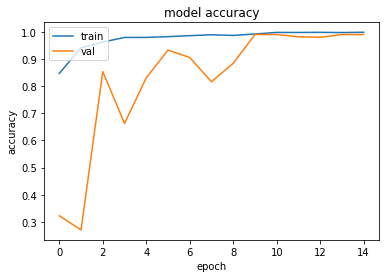

In [18]:
from matplotlib import pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

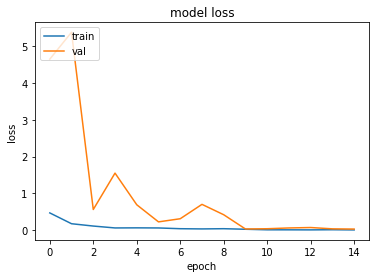

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()